In [1]:
# Imports
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [2]:
# Load data
mnist = tensorflow.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Map inputs to [-1/+1]
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1
print("Training shape: ", x_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
Training shape:  (60000, 28, 28)


In [3]:
# Flatten data into 1d array
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [4]:
# Select latent space size
latent_dim = 100

In [5]:
def build_gen (latent_dim):
    i = Input(shape=(latent_dim))
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(D, activation="tanh")(x)

    model = Model(i, x)
    return model

In [6]:
def build_discr(img_size):
    i = Input(shape=(img_size,))
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation="sigmoid")(x)

    model = Model(i, x)
    return model

In [7]:
# Compile both models
discriminator = build_discr(D)
discriminator.compile(
    loss="binary_crossentropy",
    optimizer=Adam(0.0002, 0.5),
    metrics=["accuracy"]
)

generator = build_gen(latent_dim)

z = Input(shape=(latent_dim,))
img = generator(z)
discriminator.trainable = False

fake_pred = discriminator(img)

gan = Model(z, fake_pred)
gan.compile(
    loss="binary_crossentropy",
    optimizer=Adam(0.0002, 0.5)
)

In [8]:
# Config for training
batch_size = 32
epochs = 30000
sample_period = 200

ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

d_losses = []
g_losses = []

if not os.path.exists("images"):
    os.mkdir("images")

In [9]:
def sample_images(epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, latent_dim)
    imgs = generator.predict(noise)

    imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(imgs[idx].reshape(H, W), cmap="gray")
            axs[i, j].axis("off")
            idx += 1
    fig.savefig("images/%d.png" % epoch)
    plt.close()

In [10]:
# Main train loop
for epoch in range(epochs):
    # Select a random batch of images
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]

    # Generate fake images
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)

    # Train discriminator
    r = discriminator.fit(real_imgs, ones, verbose=0)
    d_loss_real, d_acc_real = r.history["loss"][0], r.history["accuracy"][0]
    r = discriminator.fit(fake_imgs, zeros, verbose=0)
    d_loss_fake, d_acc_fake = r.history["loss"][0], r.history["accuracy"][0]
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)

    # Train generator
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = gan.train_on_batch(noise, ones)


    # Save losses
    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if (epoch % 100 == 0):
        print(f"Epoch: {epoch + 1}/{epochs}, D_loss: {d_loss:.2f}, D_acc: {d_acc:.2f}, G_loss: {g_loss:.2f}")
    
    if (epoch % sample_period == 0):
        sample_images(epoch)

Epoch: 1/30000, D_loss: 0.67, D_acc: 0.50, G_loss: 0.59
Epoch: 101/30000, D_loss: 0.01, D_acc: 1.00, G_loss: 4.71
Epoch: 201/30000, D_loss: 0.34, D_acc: 0.88, G_loss: 4.39
Epoch: 301/30000, D_loss: 0.13, D_acc: 0.98, G_loss: 3.12
Epoch: 401/30000, D_loss: 0.70, D_acc: 0.59, G_loss: 1.72
Epoch: 501/30000, D_loss: 0.68, D_acc: 0.44, G_loss: 0.75
Epoch: 601/30000, D_loss: 0.65, D_acc: 0.61, G_loss: 0.72
Epoch: 701/30000, D_loss: 0.62, D_acc: 0.70, G_loss: 0.79
Epoch: 801/30000, D_loss: 0.60, D_acc: 0.66, G_loss: 0.81
Epoch: 901/30000, D_loss: 0.65, D_acc: 0.64, G_loss: 0.83
Epoch: 1001/30000, D_loss: 0.63, D_acc: 0.67, G_loss: 0.82
Epoch: 1101/30000, D_loss: 0.59, D_acc: 0.72, G_loss: 0.84
Epoch: 1201/30000, D_loss: 0.66, D_acc: 0.58, G_loss: 0.83
Epoch: 1301/30000, D_loss: 0.55, D_acc: 0.77, G_loss: 0.92
Epoch: 1401/30000, D_loss: 0.57, D_acc: 0.75, G_loss: 0.97
Epoch: 1501/30000, D_loss: 0.52, D_acc: 0.81, G_loss: 0.97
Epoch: 1601/30000, D_loss: 0.59, D_acc: 0.69, G_loss: 1.00
Epoch: 17

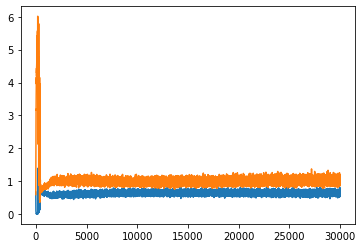

In [11]:
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.show()